# 1. Insight Summary

## Loading libraries

In [3]:
import torch

print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

2.0.1+cpu
cpu


In [1]:
import os, sys, glob
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from sklearn.metrics import precision_score, recall_score
from transformers import BertForSequenceClassification, BertTokenizerFast, BertJapaneseTokenizer, Trainer, TrainingArguments
from transformers import pipeline, Pipeline
from datasets import load_dataset, Dataset

pd.options.display.float_format = "{:.4f}".format

## Preparing data

In [6]:
DATA_DIR = os.path.join(os.getcwd(), 'data\\STARS_4月')

In [4]:
# 店舗名が格納されたDataFrame
# 'store_code', 'store_name'
store_df_origin = pd.read_csv(os.path.join(DATA_DIR, 'store.csv'), encoding='cp932')
store_df = store_df_origin[['store_code', 'store_name']]
store_df = store_df.drop_duplicates()
print(store_df.shape)

# 回答の属性データ等
# 'answer_id', 'store_code', 'member_id', 'majica_no',
# 'majica_no_category', 'sex', 'age', 'occupation', 'create_datetime',
# 'sending_datetime', 'buying_amount'
answer_df_origin = pd.read_csv(os.path.join(DATA_DIR, 'answer.csv'), encoding='cp932')
answer_df = answer_df_origin[['answer_id', 'store_code', 'member_id', 'majica_no', 'majica_no_category', 'sex', 'age', 'occupation', 'create_datetime', 'sending_datetime', 'buying_amount']]
# answer_df = answer_df_origin[['answer_id', 'store_code']]
print(answer_df.shape)

# 回答データ
# 'question_answer_id', 'answer_id', 'question_id', 'answer_question'
qa_df = pd.read_csv(os.path.join(DATA_DIR, 'question_answer.csv'), encoding='cp932')
voc_df = qa_df[qa_df['answer_question'].notnull()][['question_answer_id', 'answer_id', 'question_id', 'answer_question']]
print(voc_df.shape)

(832, 2)
(3142615, 11)


C:\Users\000063JP6\AppData\Local\Temp\ipykernel_13900\3177550527.py:19: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  qa_df = pd.read_csv(os.path.join(DATA_DIR, 'question_answer.csv'), encoding='cp932')


(174035, 4)


In [5]:
# 結合
voc_all_df = pd.merge(
    left=pd.merge(left=voc_df, right=answer_df, on='answer_id'),
    right=store_df,
    on='store_code', 
    how='inner')

In [6]:
# 確認と保存、メモリ解放
assert voc_df.shape[0] == voc_all_df.shape[0], 'DataFrameのサイズが違います'

voc_all_df.to_csv(os.path.join(DATA_DIR, 'data.csv'), encoding='cp932', index=False)

del store_df_origin, store_df, answer_df_origin, answer_df, qa_df, voc_df, voc_all_df

### VoC

In [79]:
voc_all_df = pd.read_csv(
    os.path.join(DATA_DIR, 'data.csv'), encoding='cp932')

print(voc_all_df.columns)

voc_all_df = voc_all_df[['answer_question', 'store_name', 'buying_amount']]
print(voc_all_df.shape)

voc_all_df

Index(['question_answer_id', 'answer_id', 'question_id', 'answer_question',
       'store_code', 'member_id', 'majica_no', 'majica_no_category', 'sex',
       'age', 'occupation', 'create_datetime', 'sending_datetime',
       'buying_amount', 'store_name'],
      dtype='object')
(174035, 3)


,answer_question,store_name,buying_amount
0,品物豊富で何でもそろう！クーポンがあったり、大盛り肉が安くて助かる！幼児用の立つカートがあっ...,MEGAドン・キホーテ長野店,14025.0000
1,他店に比べて商品が多いので、欲しい商品を探すのも大変だが、ドンキは探すことも楽しさに繋がるの...,MEGAドン・キホーテ長野店,3695.0000
2,近い。,MEGAドン・キホーテ長野店,1620.0000
3,レジの時にクーポンのご利用はありますかと一言あると嬉しいです。,MEGAドン・キホーテ長野店,756.0000
4,ミニトマト、ハナノアが安いから。,MEGAドン・キホーテ長野店,753.0000
...,...,...,...
174030,他のドンキホーテも、あまり好きではない。物がごちゃごちゃして、先をみわたすことができず、目当...,MEGAドン・キホーテUNY大覚寺店,2835.0000
174031,ほしいのがあるので。,ドン・キホーテ セブンパークアリオ柏店,877.0000
174032,安い品が多いから！,ドン・キホーテ セブンパークアリオ柏店,877.0000
174033,いろんなコンタクトレンズあるから,ドン・キホーテ セブンパークアリオ柏店,3035.0000


### Store

In [7]:
store_list = voc_all_df['store_name'].unique()
len(store_list)

487

In [8]:
with open(os.path.join(DATA_DIR, 'store_list.txt'), mode='w', encoding='cp932') as f:
    f.write('\n'.join(store_list))

## EDA

In [9]:
voc_all_df.groupby('store_name')['answer_question'].count().sort_values(ascending=False)
# .to_csv(os.path.join(DATA_DIR, 'store_list.csv'))

store_name
MEGAドン・キホーテUNY東海通店        1763
MEGAドン・キホーテ大森山王店          1680
MEGAドン・キホーテ 福重店           1427
二俣川店                      1387
MEGAドン・キホーテUNY稲沢東店        1339
                          ... 
キラキラドンキ ダイバーシティ東京 プラザ店       4
ミチドンキ NEOPASA清水店             4
情熱職人東松山店                     2
お菓子ドンキ・お酒ドンキ店                2
情熱職人昭島店                      1
Name: answer_question, Length: 487, dtype: int64

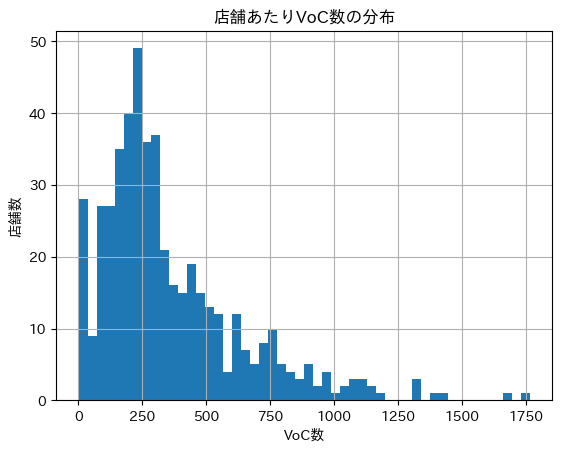

In [10]:
voc_all_df.groupby('store_name')['answer_question'].count().sort_values(ascending=False).hist(bins=50)
plt.title('店舗あたりVoC数の分布')
plt.xlabel('VoC数')
plt.ylabel('店舗数')
plt.show()

In [11]:
voc_all_df.groupby('store_name')['buying_amount'].sum().sort_values(ascending=False).astype(int)
# .to_csv(os.path.join(DATA_DIR, ''))

store_name
MEGAドン・キホーテUNY東海通店     7948933
MEGAドン・キホーテ大森山王店       6926261
MEGAドン・キホーテ 福重店        6691316
MEGAドン・キホーテ豊橋店         6351837
MEGAドン・キホーテUNY稲沢東店     5759663
                        ...   
情熱職人昭島店                  12360
ドン・キホーテ ららぽーと立川立飛店        8898
ドン・キホーテ セブンパークアリオ柏店       5649
ミチドンキ NEOPASA清水店          4692
お菓子ドンキ・お酒ドンキ店             1241
Name: buying_amount, Length: 487, dtype: int32

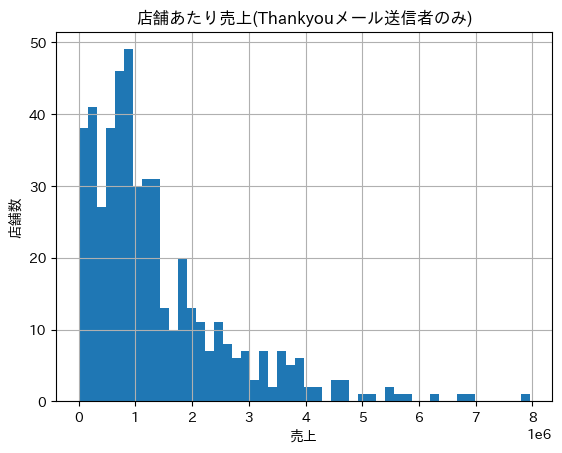

In [12]:
voc_all_df.groupby('store_name')['buying_amount'].sum().sort_values(ascending=False).astype(int).hist(bins=50)
plt.title('店舗あたり売上(Thankyouメール送信者のみ)')
plt.xlabel('売上')
plt.ylabel('店舗数')
plt.show()

## Inference

In [128]:
target_store_list = ['MEGAドン・キホーテUNY東海通店', 'MEGAドン・キホーテUNY 横浜大口店', 'ドン・キホーテ 川西店', 'ドン・キホーテ 六本木店','小樽店']
# MEGAドン・キホーテUNY東海通店: 1763
# MEGAドン・キホーテUNY 横浜大口店: 809
# 川西店: 304
# ドン・キホーテ 六本木店: 136
# 小樽店: 92

78788

In [82]:
_df = voc_all_df.query('store_name in @target_store_list')
from compute_sentiment_score import compute_sentiment_score_by_BERT
FT_MODEL_DIR = '../sentiment_classification/'

_df = compute_sentiment_score_by_BERT(
    df=_df, 
    model_path=os.path.join(FT_MODEL_DIR, 'results_bert-base-japanese-v3_50'),
    tokenizer_model='cl-tohoku/bert-large-japanese-v2')

c:\Users\mak1_\Documents\Code\nlp\.venv\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
C:\Users\mak1_\AppData\Local\Temp\ipykernel_5340\4099118025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['sentiment_results'] = _df['answer_question'].apply(lambda x: sentiment_analyzer(x, return_all_scores=True))


In [ ]:
_df['answer_question'].apply(lambda x: len(x)).sum()

3104件で1分20秒程度

- label (str) – The label predicted.
- score (float) – The corresponding probability.

In [3]:
# _df.to_csv(os.path.join(DATA_DIR, 'scores_for_target_stores.csv'), index=False)
_df = pd.read_csv(os.path.join(DATA_DIR, 'scores_for_target_stores.csv'))

In [4]:
from compute_sentiment_score import compute_sentiment_score
_df = compute_sentiment_score(_df)

In [5]:
_df

,answer_question,store_name,buying_amount,sentiment_results,sentiment_label,sentiment_score
0,よかったみたいなのでまた利用します。,ドン・キホーテ 川西店,1665.0000,"[[{'label': 'NEGATIVE', 'score': 2.82993642031...",positive,0.9960
1,リンドールのチョコレートをお安く提供してほしいです,ドン・キホーテ 川西店,5615.0000,"[[{'label': 'NEGATIVE', 'score': 3.36916200467...",positive,0.9968
2,家から近いから。,ドン・キホーテ 川西店,1235.0000,"[[{'label': 'NEGATIVE', 'score': 0.00019125168...",neutral,0.4472
3,商品が安いから,ドン・キホーテ 川西店,2130.0000,"[[{'label': 'NEGATIVE', 'score': 0.00199854490...",positive,0.8022
4,良い,ドン・キホーテ 川西店,6290.0000,"[[{'label': 'NEGATIVE', 'score': 3.88607950299...",positive,0.9858
...,...,...,...,...,...,...
3099,いつも決まって買う物があるので,ドン・キホーテ 六本木店,2935.0000,"[[{'label': 'NEGATIVE', 'score': 2.92688164336...",neutral,0.4472
3100,焼き芋がおいしすぎる??,ドン・キホーテ 六本木店,3165.0000,"[[{'label': 'NEGATIVE', 'score': 0.99972754716...",negative,0.0901
3101,六本木店は透明のプラ袋を置いていないので、焼き芋を購入したら、必ずプラ袋に入れてほしい。こち...,ドン・キホーテ 六本木店,1130.0000,"[[{'label': 'NEGATIVE', 'score': 0.99994206428...",negative,0.0117
3102,周辺2kmくらいに、ドンキに匹敵するようなオモ楽しいお店はありませんから！,ドン・キホーテ 六本木店,2360.0000,"[[{'label': 'NEGATIVE', 'score': 2.63045658357...",neutral,0.4472


store_name:  MEGAドン・キホーテUNY東海通店
score_avg:  68.6983131159475
score_median:  0.9429210673618121
sentiment_label
positive    1102
negative     351
neutral      310
Name: count, dtype: int64


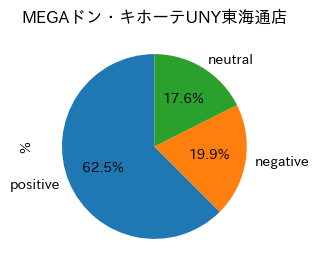

store_name:  MEGAドン・キホーテUNY 横浜大口店
score_avg:  66.39181242436081
score_median:  0.8854002667385427
sentiment_label
positive    473
neutral     171
negative    165
Name: count, dtype: int64


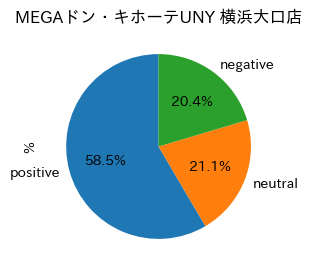

store_name:  ドン・キホーテ 川西店
score_avg:  74.34988379207358
score_median:  0.9708651016054768
sentiment_label
positive    213
neutral      46
negative     45
Name: count, dtype: int64


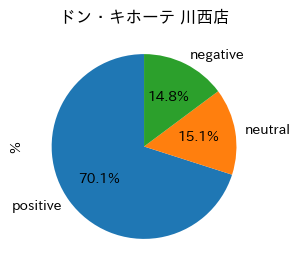

store_name:  ドン・キホーテ 六本木店
score_avg:  68.96671989235092
score_median:  0.9032083775075734
sentiment_label
positive    90
negative    26
neutral     20
Name: count, dtype: int64


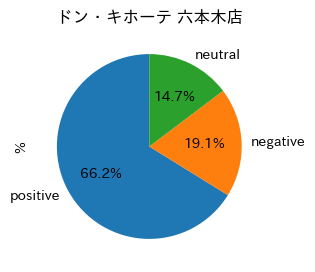

store_name:  小樽店
score_avg:  74.71077252062499
score_median:  0.9473787839952803
sentiment_label
positive    62
neutral     19
negative    11
Name: count, dtype: int64


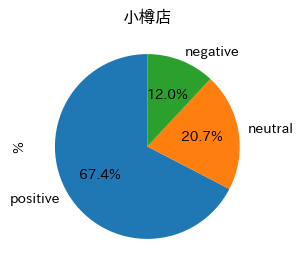

In [141]:
scores = []

for store_name in target_store_list:
  target_df = _df.query('store_name == @store_name')
  print('store_name: ', store_name)
  score_avg = target_df['sentiment_score'].mean() * 100
  score_median = target_df['sentiment_score'].median()
  print('score_avg: ', score_avg)
  print('score_median: ', score_median)
  print(target_df['sentiment_label'].value_counts())
  target_df['sentiment_label'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(3, 3), startangle=90)
  plt.title(store_name)
  plt.ylabel('%')
  plt.show()

  scores.append([store_name, score_avg])

In [142]:
_df['store_name'].value_counts()

store_name
MEGAドン・キホーテUNY東海通店      1763
MEGAドン・キホーテUNY 横浜大口店     809
ドン・キホーテ 川西店              304
ドン・キホーテ 六本木店             136
小樽店                       92
Name: count, dtype: int64

,店舗名,スコア平均
4,小樽店,74.7108
2,ドン・キホーテ 川西店,74.3499
3,ドン・キホーテ 六本木店,68.9667
0,MEGAドン・キホーテUNY東海通店,68.6983
1,MEGAドン・キホーテUNY 横浜大口店,66.3918


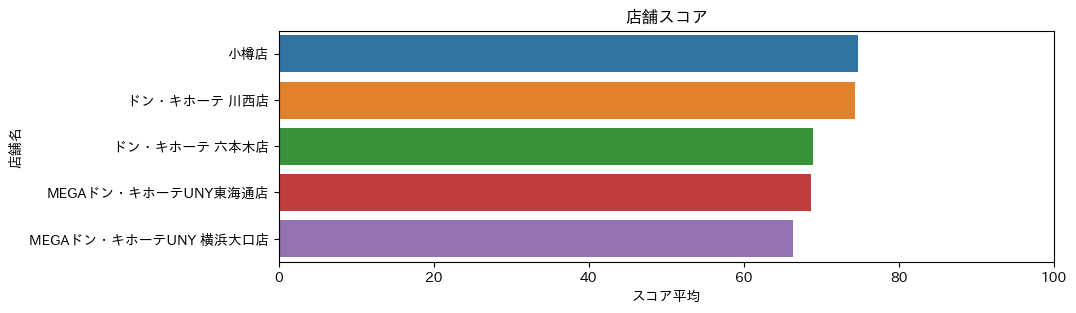

In [143]:
score_df = pd.DataFrame(scores, columns=['店舗名', 'スコア平均']).sort_values('スコア平均', ascending=False)

display(score_df)

fig, ax = plt.subplots(figsize=(10, 3))
sns.barplot(x='スコア平均', y='店舗名', data=score_df, ax=ax)
ax.set_title('店舗スコア')
ax.set_xlim(0, 100)
plt.show()

In [144]:
_df[['answer_question', 'store_name', 'buying_amount', 'sentiment_label', 'sentiment_score']]

,answer_question,store_name,buying_amount,sentiment_label,sentiment_score
0,よかったみたいなのでまた利用します。,ドン・キホーテ 川西店,1665.0000,positive,0.9960
1,リンドールのチョコレートをお安く提供してほしいです,ドン・キホーテ 川西店,5615.0000,positive,0.9968
2,家から近いから。,ドン・キホーテ 川西店,1235.0000,neutral,0.4472
3,商品が安いから,ドン・キホーテ 川西店,2130.0000,positive,0.8022
4,良い,ドン・キホーテ 川西店,6290.0000,positive,0.9858
...,...,...,...,...,...
3099,いつも決まって買う物があるので,ドン・キホーテ 六本木店,2935.0000,neutral,0.4472
3100,焼き芋がおいしすぎる??,ドン・キホーテ 六本木店,3165.0000,negative,0.0901
3101,六本木店は透明のプラ袋を置いていないので、焼き芋を購入したら、必ずプラ袋に入れてほしい。こち...,ドン・キホーテ 六本木店,1130.0000,negative,0.0117
3102,周辺2kmくらいに、ドンキに匹敵するようなオモ楽しいお店はありませんから！,ドン・キホーテ 六本木店,2360.0000,neutral,0.4472
